### Importing libraries

In [170]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

### Configuring hardware

In [171]:
physical_devices = tf.config.list_physical_devices()

print(physical_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [172]:
tf.config.set_visible_devices(physical_devices[1], 'GPU')

### Loading data

##### Processed dataset with pre-selecter features (by Random Forest)

In [173]:
# data_train = pd.read_csv('data/processed/train_meaningfull.csv')
# data_test = pd.read_csv('data/processed/test_meaningfull.csv')

##### Raw dataset with (>500 features)

In [174]:
data_train = pd.read_csv('data/raw/train.csv')
data_test = pd.read_csv('data/raw/test.csv')

##### Processing data

In [175]:
X_train = data_train.drop('Activity', axis='columns')
y_train = data_train['Activity']
y_train_encoded = pd.get_dummies(y_train)

In [176]:
X_test = data_test.drop('Activity', axis='columns')
y_test = data_test['Activity']
y_test_encoded = pd.get_dummies(y_test)

### Build model

In [177]:
from tensorflow import keras
from keras import regularizers
from keras import layers

regularizer = regularizers.l2(l=0.01)

model = keras.Sequential(
  [
    layers.Input(X_train.shape[-1]),
    layers.Dense(128, activation="relu", kernel_regularizer=regularizer),
    layers.Dropout(0.2),
    layers.Dense(256, activation="relu", kernel_regularizer=regularizer),
    layers.Dropout(0.2),
    layers.Dense(256, activation="relu", kernel_regularizer=regularizer),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu", kernel_regularizer=regularizer),
    layers.Dropout(0.4),
    layers.Dense(6, activation="sigmoid"),
  ]
)
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70 (Dense)            (None, 128)               72064     
                                                                 
 dropout_50 (Dropout)        (None, 128)               0         
                                                                 
 dense_71 (Dense)            (None, 256)               33024     
                                                                 
 dropout_51 (Dropout)        (None, 256)               0         
                                                                 
 dense_72 (Dense)            (None, 256)               65792     
                                                                 
 dropout_52 (Dropout)        (None, 256)               0         
                                                                 
 dense_73 (Dense)            (None, 128)             

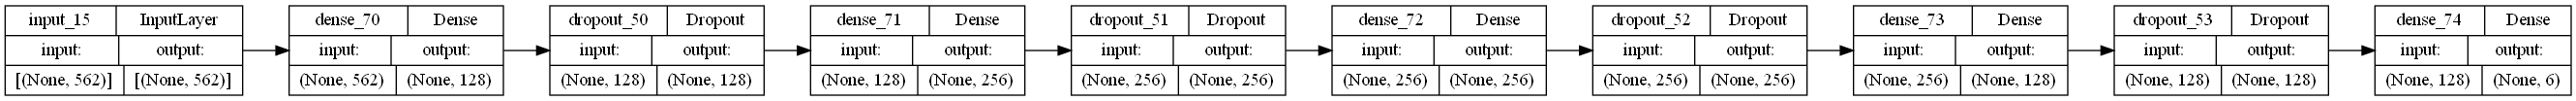

In [178]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [179]:
optimizer = keras.optimizers.Adadelta(learning_rate=2e-1, rho=0.95, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics='accuracy')

### Train model

#### Save checkpoint

In [180]:
CHECKPOINT_PATH = 'models/checkpoints/dnn_best.keras'

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
  filepath=CHECKPOINT_PATH,
  save_weights_only=False,
  monitor='val_accuracy',
  mode='max',
  save_best_only=True
)

In [181]:
history = model.fit(
  X_train,
  y_train_encoded,
  batch_size=1000,
  epochs=80,
  verbose=1,
  validation_split=0.3,
  callbacks=[model_checkpoint_callback]
)

Epoch 1/80
6/6 [==============================] - 1s 85ms/step - loss: 9.8856 - accuracy: 0.2035 - val_loss: 9.6940 - val_accuracy: 0.2906
Epoch 2/80
6/6 [==============================] - 0s 21ms/step - loss: 9.7250 - accuracy: 0.2299 - val_loss: 9.5455 - val_accuracy: 0.3173
Epoch 3/80
6/6 [==============================] - 0s 21ms/step - loss: 9.5871 - accuracy: 0.2499 - val_loss: 9.3894 - val_accuracy: 0.3341
Epoch 4/80
6/6 [==============================] - 0s 20ms/step - loss: 9.4454 - accuracy: 0.2925 - val_loss: 9.2175 - val_accuracy: 0.3454
Epoch 5/80
6/6 [==============================] - 0s 20ms/step - loss: 9.3076 - accuracy: 0.3169 - val_loss: 9.0618 - val_accuracy: 0.3522
Epoch 6/80
6/6 [==============================] - 0s 21ms/step - loss: 9.1691 - accuracy: 0.3373 - val_loss: 8.9084 - val_accuracy: 0.3939
Epoch 7/80
6/6 [==============================] - 0s 14ms/step - loss: 9.0455 - accuracy: 0.3558 - val_loss: 8.7640 - val_accuracy: 0.3880
Epoch 8/80
6/6 [===========

### Evaluate model performance

In [182]:
best_checkpoint = keras.models.load_model(CHECKPOINT_PATH)

loss, score = best_checkpoint.evaluate(X_test, y_test_encoded)

print(score)

93/93 [==============================] - 0s 3ms/step - loss: 3.9454 - accuracy: 0.8751
0.8751272559165955


Text(0.5, 1.0, 'Accuracy Curves')

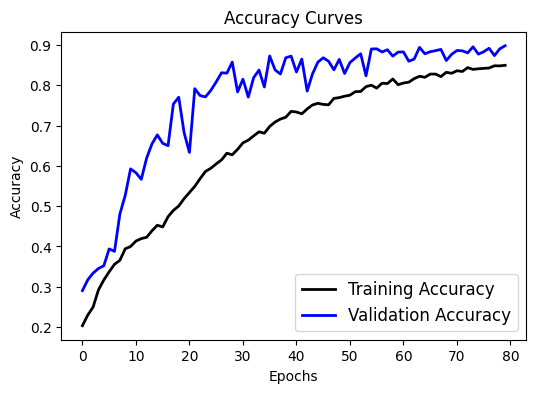

In [183]:
# Plotting the accuracy curve
plt.figure(figsize=[6, 4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=12)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)